Running the Multibox Object Detector
====================

This notebook shows an example usage of the Multibox approach, described in the paper

* Dumitru Erhan, Christian Szegedy, Alexander Toshev, Dragomir Anguelov.
Scalable Object Detection using Deep Neural Networks. arXiv:1312.2249. [pdf](http://arxiv.org/pdf/1312.2249v1)

The actual model may be slightly different from the one described in the original model, in the sense that:
- The original Inception module is finetuned a little bit, e.g. the maxpooling layer is replaced with average pooling layer, and Relu is replaced with Relu6 (i.e. max(min(x, 0), 6).
- The model is trained with batch normalization. During inference as we show here, there is no batch normalization layers: since all it does during inference time is a scale and a bias, they are "folded in" to the previous convolution layer. As a note, every parameterized layer (convolution and fully connected) is followed by a batch normalization layer during training.

Dependencies
--------------
This notebook is designed to have as few dependencies as possible:
* Standard Python scientific stack: NumPy, Matplotlib, scikits-image, IPython. Those libraries can also be installed as a part of one of the scientific packages for Python, such as Anaconda or Canopy.
* Google protobuf library for Python.
* Caffe2 deep learning framework (installation instructions), which can be obtained at [this address](http://github.com/Yangqing/caffe2/). The reason we did not use Caffe is that some specifications of our system at Google does not use the Caffe convention. For example, the data is stored in the order height-width-channel instead of channel-height-width, and the padding convention is slightly different. Caffe2 provides a compatible implementation that matches our model.

In [1]:
from IPython import display
from matplotlib import pyplot
import numpy as np
import os
from skimage import io, transform
import sys
%matplotlib inline

# Make sure that you set this to the location your caffe2 library lies.
caffe2_root = '/home/user/caffe2-release/'
sys.path.insert(0, os.path.join(caffe2_root, 'gen'))

# After setting the caffe2 root path, we will import all the caffe2 libraries needed.
from caffe2.proto import caffe2_pb2
from pycaffe2 import core, net_drawer, workspace, visualize

loaded nvd3 IPython extension
run nvd3.IPython_wrapper.initialize_javascript() to set up the notebook
help(nvd3.IPython_wrapper.initialize_javascript) for options
Couldn't import dot_parser, loading of dot files will not be possible.


(note: if you see warning messages above, it might be coming from some dependency libraries like pydot, and you do not need to worry about it.)

Loading the model
-------------------
First, let's load the multibox model. It is composed of two parts: one defines the network architecture, and one provides the parameters that the network uses.

In [2]:
# net is the network definition.
net = caffe2_pb2.NetDef()
net.ParseFromString(open('multibox_net.pb').read())
with open('multibox_net.pb', 'w') as fid:
    fid.write(net.SerializeToString())

# tensors contain all the parameters used in the net.
# The multibox model is relatively large so we have stored the parameters in multiple files.
import glob
file_parts = glob.glob("multibox_tensors.pb.part*")
file_parts.sort()
tensors = caffe2_pb2.TensorProtos()
tensors.ParseFromString(''.join(open(f).read() for f in file_parts))

Let's take a look at the model architecture using Caffe2's net_drawer. Warning: this network is very deep, so you might need to scroll down to show the whole network. To assist your scroll, we are showing the flow direction from the top to the bottom, so the input image is filled into the top of the graph. Each node in this graph is an operator (loosely equivalence of a layer). We are showing activations like ReLU as layers as well. The type of the operators are shown in the name of each node.

The graph is quite tall, so you may need to scroll down.

Visualizing network: multibox


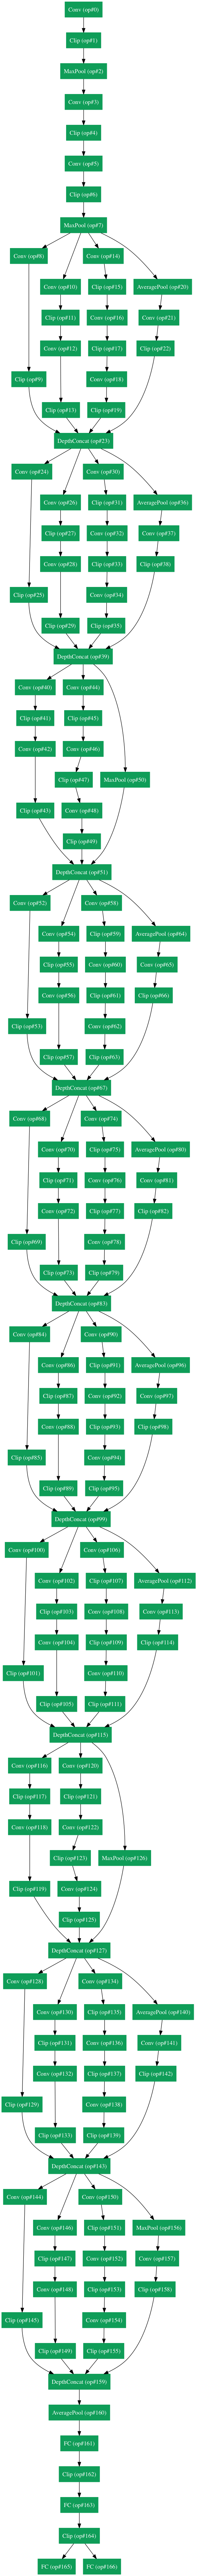

In [3]:
# Note that the following line hides the intermediate blobs and only shows the operators.
# If you want to show all the blobs as well, use the commented GetPydotGraph line.
graph = net_drawer.GetPydotGraphMinimal(net.op, name="multibox", rankdir='TB')
#graph = net_drawer.GetPydotGraph(net.op, name="inception", rankdir='TB')

print 'Visualizing network:', net.name
display.Image(graph.create_png(), width=200)

If the image shown above is too small, try right-click it and select "Open image in new tab". This will show a larger version.

Instantiate the Model in Caffe2
------------------------------------
If you are familiar with Caffe, you may notice that Caffe2 instantiates a model slightly differently - it deals with the network and the parameters separately, and has a specific device_option field that specifies where to run the model. This allows one to have more fine-grained control over things.

In [4]:
DEVICE_OPTION = caffe2_pb2.DeviceOption()
# Let's use CPU in our example.
DEVICE_OPTION.device_type = caffe2_pb2.CPU

# If you have a GPU and want to run things there, uncomment the below two lines.
# If you have multiple GPUs, you also might want to specify a gpu id.
#DEVICE_OPTION.device_type = caffe2_pb2.CUDA
#DEVICE_OPTION.cuda_gpu_id = 0

# Caffe2 has a concept of "workspace", which is similar to that of Matlab. Each workspace
# is a self-contained set of tensors and networks. In this case, we will just use the default
# workspace, so we won't dive too deep into it.
workspace.SwitchWorkspace('default')

# First, we feed all the parameters to the workspace.
for param in tensors.protos:
    workspace.FeedBlob(param.name, param, DEVICE_OPTION)
# The network expects an input blob called "input", which we create here.
# The content of the input blob is going to be fed when we actually do
# classification.
workspace.CreateBlob("input")
# Specify the device option of the network, and then create it.
net.device_option.CopyFrom(DEVICE_OPTION)
workspace.CreateNet(net)

True

The multibox model is trained to predict 800 bounding boxes. Specifically:

- location is a 3200-dimensional vector, with each 4 values corresponding to a bounding box with coordinates corresponding to [xmin, ymin, xmax, ymax].
- confidence is a 800-dimensional vector being the logits of the confidence for each predicted box. The higher a confidence value is, the more likely this box is to contain a potential object.

Also, the direct output of the location values are not the raw locations on the image, but rather a value with respect to a prior distribution of that coordinate. We compute this prior distribution separately from training data, with one Gaussian distribution with respect to each index in the 3200-dimensional vector. The RunMultiboxOnImage function also takes care of recovering the original coordinates.

(If you recently played with the Inception notebook we also released, you may have noticed that the image pre-processing is slightly different. We subtracted 117 in the other example there. Recently we found that there is really little difference in the mean value one uses, so we prefer things to be simple.)

We will put all the pre- and post-processing in a wrapper function RunMultiboxOnImage() for demonstration purposes.

In [5]:
# location_prior defines the gaussian distribution for each location: it is a 3200x2
# matrix with the first dimension being the std and the second being the mean.
LOCATION_PRIOR = np.loadtxt('ipriors800.txt')

def RunMultiboxOnImage(image_file, location_prior):
    img = io.imread(image_file)
    resized_img = transform.resize(img, (224, 224))
    normalized_image = resized_img.reshape((1, 224, 224, 3)).astype(np.float32) - 0.5
    workspace.FeedBlob("input", normalized_image, DEVICE_OPTION)
    workspace.RunNet("multibox")
    location = workspace.FetchBlob("imagenet_location_projection").flatten(),
    # Recover the original locations
    location = location * location_prior[:,0] + location_prior[:,1]
    location = location.reshape((800, 4))
    confidence = workspace.FetchBlob("imagenet_confidence_projection").flatten()
    return location, confidence

def PrintBox(loc, height, width, style='r-'):
    """A utility function to help visualizing boxes."""
    xmin, ymin, xmax, ymax = loc[0] * width, loc[1] * height, loc[2] * width, loc[3] * height 
    pyplot.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], style)

Let's show a simple example with an image of a puffin standing on a cliff, and show the top five predicted boxes.

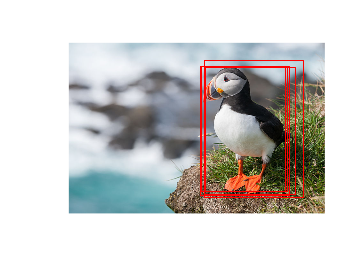

In [6]:
location, confidence = RunMultiboxOnImage("not-penguin.jpg", LOCATION_PRIOR)

img = io.imread("not-penguin.jpg")
pyplot.imshow(img)
pyplot.axis("off")
# Let's show the most confident 5 predictions.
# Note that argsort sorts things in increasing order.
sorted_idx = np.argsort(confidence)
for idx in sorted_idx[-5:]:
    PrintBox(location[idx], img.shape[0], img.shape[1])

Notice how the predicted boxes converge to the single dominant object in this image. The model does not explicitly force the predicted boxes to be separated from each other, so there is one single salient object in the image, it is possible that there are multiple predictions corresponding to it. In other words, a non-maximal suppression could be applied as a post-processing step to remove duplciates.

Here is an example that shows how we detect objects in a more complex scene, where there are multiple objects (in this case, persons) present.

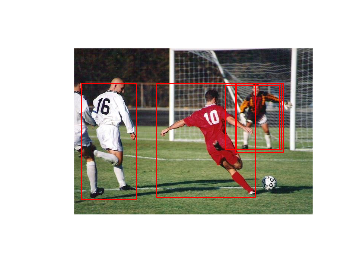

In [7]:
location, confidence = RunMultiboxOnImage("Football_iu_1996.jpg", LOCATION_PRIOR)

img = io.imread("Football_iu_1996.jpg")
pyplot.imshow(img)
pyplot.axis("off")
# Let's show the most confident 5 predictions.
# Note that argsort sorts things in increasing order.
sorted_idx = np.argsort(confidence)
for idx in sorted_idx[-5:]:
    PrintBox(location[idx], img.shape[0], img.shape[1])

The model is not trained to do person detection particularly, but it does a reasonable job: the first 5 boxes find the goalkeeper (three times), the red team member, and one of the white team members. Note that there are a total of 800 detected boxes, so it is likely that there are boxes detecting individual players as well.